### Goal: Evaluation the time it take to compute CL lensing quantities using `cluster-toolkit` directly or the version wrapped into `CLMM` 

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
from astropy.cosmology import FlatLambdaCDM
import cluster_toolkit as ct
from clmm import modeling

#### Define a cosmology and fix cluster concentration

In [ ]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)
concentration = 4 #arbitrary
Omega_m = cosmo.Om0

#### Functions to compute the `DeltaSigma` or the `g_t` profiles, either from `cl-toolkit` or from `CLMM`.
It's done for arrays of masses and redshifts. Results are returned in a 3D array of size `Nmass x Nz x Nr`

In [158]:
def test_ct_DeltaSigma(cl_masses, cl_redshifts, R_perp):
    sigma_r_proj = np.logspace(-3, 4, 1000) # this is so that CT runs in the same way as how it's called in CLMM
    res = np.zeros([len(cl_masses), len(cl_redshifts), len(R_perp)])
    for i,mass in enumerate(cl_masses):
        for j,z in enumerate(cl_redshifts):
            Om = Omega_m*(1+z)**3. # Need Omega_m(z) in cluster-toolkit
            Sigma_nfw = ct.deltasigma.Sigma_nfw_at_R(sigma_r_proj, mass, concentration, Om)
            res[i][j] = ct.deltasigma.DeltaSigma_at_R(R_perp, sigma_r_proj, Sigma_nfw, mass, concentration, Om)
    return res

def test_clmm_DeltaSigma(cl_masses, cl_redshifts, R_perp):
    res = np.zeros([len(cl_masses), len(cl_redshifts), len(R_perp)])
    for i,mass in enumerate(cl_masses):
        for j,z in enumerate(cl_redshifts):
            res[i][j] = modeling.predict_excess_surface_density(R_perp, mass, concentration, z, cosmo=cosmo, 
                                                                 delta_mdef=200, halo_profile_model='nfw')
    return res       

def test_clmm_gammat(cl_masses, cl_redshifts, src_z, R_perp):
    res = np.zeros([len(cl_masses), len(cl_redshifts), len(R_perp)])    
    for i,mass in enumerate(cl_masses):
        for j,z in enumerate(cl_redshifts):
            res[i][j] = modeling.predict_reduced_tangential_shear(R_perp, mdelta=mass, cdelta=concentration, 
                                                           z_cluster=z, z_source=src_z, cosmo=cosmo, 
                                                           delta_mdef=200, halo_profile_model='nfw', 
                                                           z_src_model='single_plane')   
    return res

#### Define the mass, redshifts and radius arrays.
- 30 radius bins
- 20 mass bins
- 20 redshifts bins

So, 400 function calls

In [159]:
R_perp = np.logspace(-2, 1, 30) #Mpc/h comoving; distance on the sky
cl_masses = np.logspace(13.,16.,20)
cl_redshifts = np.logspace(-1,0.12,20)

#### and `timeit`!

In [160]:
%timeit res_ct_DeltaSigma = test_ct_DeltaSigma(cl_masses, cl_redshifts, R_perp)

81.8 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [161]:
%timeit res_clmm_DeltaSigma = test_clmm_DeltaSigma(cl_masses, cl_redshifts, R_perp)

111 ms ± 2.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


It takes `CLMM` takes ~35% longer to generate the `DeltaSigma` profile than it does `cluster-toolkit`. Below, a sanity check to verify they did compute the same thing.

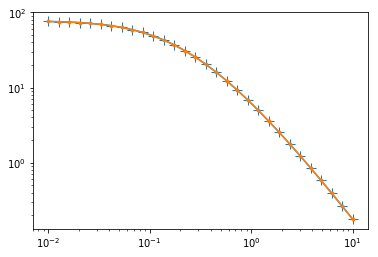

In [163]:
res_ct_DeltaSigma = test_ct_DeltaSigma(cl_masses, cl_redshifts, R_perp)
res_clmm_DeltaSigma = test_clmm_DeltaSigma(cl_masses, cl_redshifts, R_perp)
plt.loglog(R_perp, res_ct_DeltaSigma[1][2], marker='+', markersize=10)
plt.loglog(R_perp, res_clmm_DeltaSigma[1][2], marker = '.')

#### Next things to do - use prun to identify where CLMM loses time...

#### CLMM tangential shear profile computation for the same mass and redshift grid and a single source plane.

In [164]:
z_src = 3.
%timeit res_clmm_gt = test_clmm_gammat(cl_masses, cl_redshifts, z_src, R_perp)

569 ms ± 43.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The extra time compared to DeltaSigma comes from computing the angular diameter distances for Sigma_crit